In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_absolute_percentage_error, f1_score
from scipy.stats import randint
import time

In [3]:
merged_results = pd.read_csv("08_results_models/Results_All_Models.csv")
merged_results.head(3)

,row_id,segment_pred,segment_true,log_price,price_true,2stage_pred_log,2stage_pred,1stage_pred_log,1stage_pred,dummy_pred_log,dummy_pred
0,0,3,3,10.596410,39990.0,10.596410,39990.000000,10.595690,39961.245375,9.680344,15999.0
1,1,1,1,7.378384,1600.0,8.594480,5400.761699,8.771461,6446.585689,9.680344,15999.0
2,2,2,2,9.852142,18998.0,9.891968,19769.923116,9.887379,19679.402298,9.680344,15999.0


Classification

In [4]:
#Print Performance Metrics
print("      Predicted")
print(confusion_matrix(merged_results['segment_true'], merged_results['segment_pred']))
print("")
print('Classification report')
print(classification_report(merged_results['segment_true'], merged_results['segment_pred'], digits=3))

      Predicted
[[25506   952    36]
 [ 1173 13966   468]
 [   32   559  9676]]

Classification report
              precision    recall  f1-score   support

           1      0.955     0.963     0.959     26494
           2      0.902     0.895     0.899     15607
           3      0.950     0.942     0.946     10267

    accuracy                          0.939     52368
   macro avg      0.936     0.933     0.935     52368
weighted avg      0.938     0.939     0.938     52368



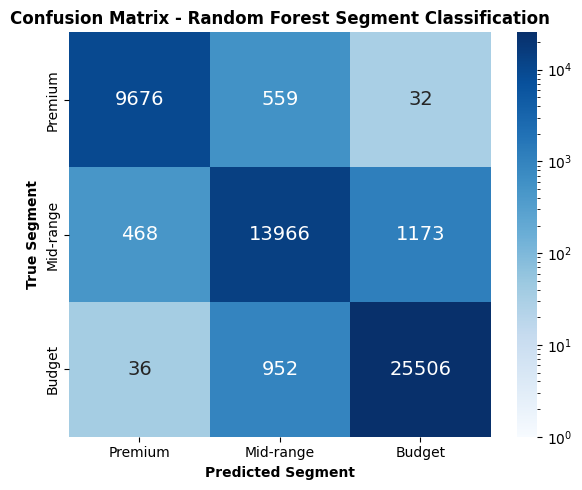

In [6]:
# Confusion matrix
cm = confusion_matrix(merged_results['segment_true'], merged_results['segment_pred'])

# Reorder Matrix Premium first
reorder = [2, 1, 0]
cm = cm[reorder, :][:, reorder]
labels = ['Premium', 'Mid-range', 'Budget']

#Plot Figure, Heat map based on Log
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', norm=LogNorm(vmin=1, vmax=np.max(cm)),
            xticklabels=labels, yticklabels=labels,annot_kws={"size": 14}, cbar=True)

plt.xlabel("Predicted Segment",fontweight='bold')
plt.ylabel("True Segment",fontweight='bold')
plt.title("Confusion Matrix - Random Forest Segment Classification", fontsize=12,fontweight='bold')
plt.tight_layout()
plt.savefig("09_results_visuals_pdf/ConfusionMatrix_Classification.pdf", format='pdf', bbox_inches='tight')
plt.show()


2-Stage

In [7]:
#Results 2 Stage Performance Metrics
mae_price = mean_absolute_error(merged_results['price_true'], merged_results['2stage_pred'])
mae_log   = mean_absolute_error(merged_results['log_price'], merged_results['2stage_pred_log'])

mape_price = mean_absolute_percentage_error(merged_results['price_true'], merged_results['2stage_pred'])
mape_log   = mean_absolute_percentage_error(merged_results['log_price'], merged_results['2stage_pred_log'])

#Print Performance Metrics
print(f"MAE  Price 2 stage : {mae_price:.2f}")
print(f"MAPE Price 2 stage : {mape_price:.4f}")
print(f"MAE  Log   2 stage : {mae_log:.4f}")
print(f"MAPE Log   2 stage : {mape_log:.4f}")

MAE  Price 2 stage : 1589.30
MAPE Price 2 stage : 0.1620
MAE  Log   2 stage : 0.1365
MAPE Log   2 stage : 0.0153


In [8]:
#Results 2 Stage Performance Metrics (ONLY CORRECT Classified)
correct_class = merged_results[merged_results['segment_pred'] == merged_results['segment_true']]
total_incorrect = len(merged_results) - len(correct_class)
percentage_correct = len(correct_class) / len(merged_results) *100
print(f"Total incorrect: {total_incorrect}")
print(f"Total correct  : {len(correct_class)}")
print(f"Percentage correct: {percentage_correct:.2f}%")

#Print Performance Metrics
mae_price = mean_absolute_error(correct_class['price_true'], correct_class['2stage_pred'])
mae_log   = mean_absolute_error(correct_class['log_price'], correct_class['2stage_pred_log'])
mape_price = mean_absolute_percentage_error(correct_class['price_true'], correct_class['2stage_pred'])
mape_log   = mean_absolute_percentage_error(correct_class['log_price'], correct_class['2stage_pred_log'])
print(f"MAE  Price 2-stage (correct classified): {mae_price:.2f}")
print(f"MAE  Log   2-stage (correct classified): {mae_log:.4f}")
print(f"MAPE Price 2-stage (correct classified): {mape_price:.4f}")
print(f"MAPE Log   2-stage (correct classified): {mape_log:.4f}")

Total incorrect: 3220
Total correct  : 49148
Perentage correct: 93.85%
MAE  Price 2-stage (correct classified): 1206.02
MAE  Log   2-stage (correct classified): 0.1187
MAPE Price 2-stage (correct classified): 0.1339
MAPE Log   2-stage (correct classified): 0.0135


Segment Specific Results

In [11]:
#Results Low Segment Performance Metrics
low_segment = merged_results[merged_results['segment_pred'] == 1]

#Print Performance Metrics
mae_price = mean_absolute_error(low_segment['price_true'], low_segment['2stage_pred'])
mae_log   = mean_absolute_error(low_segment['log_price'], low_segment['2stage_pred_log'])
mape_price = mean_absolute_percentage_error(low_segment['price_true'], low_segment['2stage_pred'])
mape_log   = mean_absolute_percentage_error(low_segment['log_price'], low_segment['2stage_pred_log'])
print(f"MAE  Price Low Segment: {mae_price:.2f}")
print(f"MAPE Price Low Segment: {mape_price:.4f}")
print(f"MAE  Log   Low Segment: {mae_log:.4f}")
print(f"MAPE Log   Low Segment: {mape_log:.4f}")

MAE  Price Low Segment: 1556.60
MAPE Price Low Segment: 0.2272
MAE  Log   Low Segment: 0.2040
MAPE Log   Low Segment: 0.0236


In [14]:
#Results Low Segment Seperated for Each Segment

#Only Classified as Segement Low
low_segmentdf = merged_results[merged_results['segment_pred'] == 1]

#Seperated on True Label
true_budget = low_segmentdf['segment_true'] == 1
true_mid    = low_segmentdf['segment_true'] == 2
true_premium= low_segmentdf['segment_true'] == 3

#Budget 
y_true_budget = low_segmentdf.loc[true_budget, 'price_true']
y_pred_budget = low_segmentdf.loc[true_budget, '2stage_pred']

#Mid 
y_true_mid = low_segmentdf.loc[true_mid, 'price_true']
y_pred_mid = low_segmentdf.loc[true_mid, '2stage_pred']

#Premium 
y_true_premium = low_segmentdf.loc[true_premium, 'price_true']
y_pred_premium = low_segmentdf.loc[true_premium, '2stage_pred']

#Performance Measures Per True Segment
mae_budget = mean_absolute_error(y_true_budget, y_pred_budget)
mape_budget = mean_absolute_percentage_error(y_true_budget, y_pred_budget)

mae_mid = mean_absolute_error(y_true_mid, y_pred_mid)
mape_mid = mean_absolute_percentage_error(y_true_mid, y_pred_mid)

mae_premium = mean_absolute_error(y_true_premium, y_pred_premium)
mape_premium = mean_absolute_percentage_error(y_true_premium, y_pred_premium)

#Print Performance Results
print("MAE of Predicted Low Segment, Splitted True Segments")
print(f"True Segment 3 (Premium)   | N = {len(y_true_premium):>5} | MAE = {mae_premium:>8.2f} | MAPE = {mape_premium:.4f}")
print(f"True Segment 2 (Mid-range) | N = {len(y_true_mid):>5} | MAE = {mae_mid:>8.2f} | MAPE = {mape_mid:.4f}")
print(f"True Segment 1 (Budget)    | N = {len(y_true_budget):>5} | MAE = {mae_budget:>8.2f} | MAPE = {mape_budget:.4f}")


MAE of Predicted Low Segment, Splitted True Segments
True Segment 3 (Premium)   | N =    32 | MAE = 29254.83 | MAPE = 0.7469
True Segment 2 (Mid-range) | N =  1173 | MAE =  6402.76 | MAPE = 0.3227
True Segment 1 (Budget)    | N = 25506 | MAE =  1298.98 | MAPE = 0.2222


In [10]:
#Results Mid Segment Performance Metrics
mid_segment = merged_results[merged_results['segment_pred'] == 2]
mae_price = mean_absolute_error(mid_segment['price_true'], mid_segment['2stage_pred'])
mae_log   = mean_absolute_error(mid_segment['log_price'], mid_segment['2stage_pred_log'])
mape_price = mean_absolute_percentage_error(mid_segment['price_true'], mid_segment['2stage_pred'])
mape_log   = mean_absolute_percentage_error(mid_segment['log_price'], mid_segment['2stage_pred_log'])

#Print Performance Metrics
print(f"MAE  Price Mid Segment: {mae_price:.2f}")
print(f"MAPE Price Mid Segment: {mape_price:.4f}")
print(f"MAE  Log   Mid Segment {mae_log:.4f}")
print(f"MAPE Log   Mid Segment {mape_log:.4f}")

MAE  Price Mid Segment: 1612.90
MAPE Price Mid Segment: 0.1030
MAE  Log   Mid Segment 0.0784
MAPE Log   Mid Segment 0.0081


In [13]:
#Only Classified as Segement Mid
low_segmentdf = merged_results[merged_results['segment_pred'] == 2]

#Seperated on True Label
true_budget = low_segmentdf['segment_true'] == 1
true_mid    = low_segmentdf['segment_true'] == 2
true_premium= low_segmentdf['segment_true'] == 3

#Budget
y_true_budget = low_segmentdf.loc[true_budget, 'price_true']
y_pred_budget = low_segmentdf.loc[true_budget, '2stage_pred']

#Mid
y_true_mid = low_segmentdf.loc[true_mid, 'price_true']
y_pred_mid = low_segmentdf.loc[true_mid, '2stage_pred']

#Premium
y_true_premium = low_segmentdf.loc[true_premium, 'price_true']
y_pred_premium = low_segmentdf.loc[true_premium, '2stage_pred']

#Performance Measures Per True Segment
mae_budget = mean_absolute_error(y_true_budget, y_pred_budget)
mape_budget = mean_absolute_percentage_error(y_true_budget, y_pred_budget)

mae_mid = mean_absolute_error(y_true_mid, y_pred_mid)
mape_mid = mean_absolute_percentage_error(y_true_mid, y_pred_mid)

mae_premium = mean_absolute_error(y_true_premium, y_pred_premium)
mape_premium = mean_absolute_percentage_error(y_true_premium, y_pred_premium)

#Print Performance Results
print("MAE of Predicted Mid Segment, Splitted True Segments")
print(f"True Segment 3 (Premium)   | N = {len(y_true_premium):>5} | MAE = {mae_premium:>8.2f} | MAPE = {mape_premium:.4f}")
print(f"True Segment 2 (Mid-range) | N = {len(y_true_mid):>5} | MAE = {mae_mid:>8.2f} | MAPE = {mape_mid:.4f}")
print(f"True Segment 1 (Budget)    | N = {len(y_true_budget):>5} | MAE = {mae_budget:>8.2f} | MAPE = {mape_budget:.4f}")


MAE of Predicted Mid Segment, Splitted True Segments
True Segment 3 (Premium)   | N =   559 | MAE =  9252.56 | MAPE = 0.2592
True Segment 2 (Mid-range) | N = 13966 | MAE =  1023.52 | MAPE = 0.0453
True Segment 1 (Budget)    | N =   952 | MAE =  5773.29 | MAPE = 0.8578


In [267]:
#Results Premium Segment Performance Metrics
high_segment = merged_results[merged_results['segment_pred'] == 3]
mae_price = mean_absolute_error(high_segment['price_true'], high_segment['2stage_pred'])
mae_log   = mean_absolute_error(high_segment['log_price'], high_segment['2stage_pred_log'])
mape_price = mean_absolute_percentage_error(high_segment['price_true'], high_segment['2stage_pred'])
mape_log   = mean_absolute_percentage_error(high_segment['log_price'], high_segment['2stage_pred_log'])

#Print Performance Metrics
print(f"MAE  Price High Segment: {mae_price:.2f}")
print(f"MAPE Price High Segment: {mape_price:.4f}")
print(f"MAE  Log   High Segment {mae_log:.4f}")
print(f"MAPE Log   High Segment {mape_log:.4f}")

MAE  Price High Segment: 1639.21
MAPE Price High Segment: 0.0805
MAE  Log   High Segment 0.0474
MAPE Log   High Segment 0.0047


In [15]:
#Only Classified as Segement High
low_segmentdf = merged_results[merged_results['segment_pred'] == 3]

#Seperated on True Label
true_budget = low_segmentdf['segment_true'] == 1
true_mid    = low_segmentdf['segment_true'] == 2
true_premium= low_segmentdf['segment_true'] == 3

#Budget 
y_true_budget = low_segmentdf.loc[true_budget, 'price_true']
y_pred_budget = low_segmentdf.loc[true_budget, '2stage_pred']

#Mid
y_true_mid = low_segmentdf.loc[true_mid, 'price_true']
y_pred_mid = low_segmentdf.loc[true_mid, '2stage_pred']

#Premium
y_true_premium = low_segmentdf.loc[true_premium, 'price_true']
y_pred_premium = low_segmentdf.loc[true_premium, '2stage_pred']

#Performance Measures Per True Segment
mae_budget = mean_absolute_error(y_true_budget, y_pred_budget)
mape_budget = mean_absolute_percentage_error(y_true_budget, y_pred_budget)

mae_mid = mean_absolute_error(y_true_mid, y_pred_mid)
mape_mid = mean_absolute_percentage_error(y_true_mid, y_pred_mid)

mae_premium = mean_absolute_error(y_true_premium, y_pred_premium)
mape_premium = mean_absolute_percentage_error(y_true_premium, y_pred_premium)

#Print Performance Results
print("MAE of Predicted Premium Segment, Splitted True Segments")
print(f"True Segment 3 (Premium)   | N = {len(y_true_premium):>5} | MAE = {mae_premium:>8.2f} | MAPE = {mape_premium:.4f}")
print(f"True Segment 2 (Mid-range) | N = {len(y_true_mid):>5} | MAE = {mae_mid:>8.2f} | MAPE = {mape_mid:.4f}")
print(f"True Segment 1 (Budget)    | N = {len(y_true_budget):>5} | MAE = {mae_budget:>8.2f} | MAPE = {mape_budget:.4f}")


MAE of Predicted Premium Segment, Splitted True Segments
True Segment 3 (Premium)   | N =  9676 | MAE =  1224.38 | MAPE = 0.0290
True Segment 2 (Mid-range) | N =   468 | MAE =  7918.43 | MAPE = 0.3135
True Segment 1 (Budget)    | N =    36 | MAE = 31507.19 | MAPE = 10.8934


Single-Stage Predictions 

In [269]:
#Results Performance Metrics
mae_price = mean_absolute_error(merged_results['price_true'], merged_results['1stage_pred'])
mae_log   = mean_absolute_error(merged_results['log_price'], merged_results['1stage_pred_log'])

mape_price = mean_absolute_percentage_error(merged_results['price_true'], merged_results['1stage_pred'])
mape_log   = mean_absolute_percentage_error(merged_results['log_price'], merged_results['1stage_pred_log'])

#Print Performance Metrics
print(f"MAE  Price 1 stage : {mae_price:.2f}")
print(f"MAPE Price 1 stage : {mape_price:.4f}")
print(f"MAE  Log   1 stage : {mae_log:.4f}")
print(f"MAPE Log   1 stage : {mape_log:.4f}")

MAE  Price 1 stage : 1627.73
MAPE Price 1 stage : 0.1638
MAE  Log   1 stage : 0.1375
MAPE Log   1 stage : 0.0154


In [16]:
#Seperated on True Label - Budget 
cheap_segment = merged_results['segment_true'] == 1
y_true_cheap = merged_results.loc[cheap_segment, 'price_true']
y_pred_cheap = merged_results.loc[cheap_segment, '1stage_pred']

#Seperated on True Label - Mid 
mid_segment = merged_results['segment_true'] == 2
y_true_mid = merged_results.loc[mid_segment, 'price_true']
y_pred_mid = merged_results.loc[mid_segment, '1stage_pred']

#Seperated on True Label - Premium 
high_segment = merged_results['segment_true'] == 3
y_true_high = merged_results.loc[high_segment, 'price_true']
y_pred_high = merged_results.loc[high_segment, '1stage_pred']

#Performance Measures Per True Segment
mae_cheap = mean_absolute_error(y_true_cheap, y_pred_cheap)
mape_cheap = mean_absolute_percentage_error(y_true_cheap, y_pred_cheap)

mae_mid = mean_absolute_error(y_true_mid, y_pred_mid)
mape_mid = mean_absolute_percentage_error(y_true_mid, y_pred_mid)

mae_high = mean_absolute_error(y_true_high, y_pred_high)
mape_high = mean_absolute_percentage_error(y_true_high, y_pred_high)

#Print Performance Results
print("MAE of Single Stage, Splitted True Segments")
print(f"Premium:    | N = {len(y_true_high)} | MAE = {mae_high:.2f} | MAPE = {mape_high:.4f}")
print(f"Mid-range:  | N = {len(y_true_mid)} | MAE = {mae_mid:.2f} | MAPE = {mape_mid:.4f}")
print(f"Budget:     | N = {len(y_true_cheap)} | MAE = {mae_cheap:.2f} | MAPE = {mape_cheap:.4f}")


MAE of Single Stage, Splitted True Segments
Premium:    | N = 10267 | MAE = 1966.42 | MAPE = 0.0487
Mid-range:  | N = 15607 | MAE = 1666.58 | MAPE = 0.0756
Budget:     | N = 26494 | MAE = 1473.61 | MAPE = 0.2603


Dummy Results

In [17]:
#Results Performance Metrics
mae_price = mean_absolute_error(merged_results['price_true'], merged_results['dummy_pred'])
mae_log   = mean_absolute_error(merged_results['log_price'], merged_results['dummy_pred_log'])

mape_price = mean_absolute_percentage_error(merged_results['price_true'], merged_results['dummy_pred'])
mape_log   = mean_absolute_percentage_error(merged_results['log_price'], merged_results['dummy_pred_log'])

#Print Performance Metrics
print(f"MAE  Price  Dummy  : {mae_price:.2f}")
print(f"MAPE Price  Dummy  : {mape_price:.4f}")
print(f"MAE  Log    Dummy  : {mae_log:.4f}")
print(f"MAPE Log    Dummy  : {mape_log:.4f}")

MAE  Price  Dummy  : 10325.47
MAPE Price  Dummy  : 1.0185
MAE  Log    Dummy  : 0.6664
MAPE Log    Dummy  : 0.0729


In [18]:
#Seperated on True Label - Budget 
cheap_segment = merged_results['segment_true'] == 1
y_true_cheap = merged_results.loc[cheap_segment, 'price_true']
y_pred_cheap = merged_results.loc[cheap_segment, 'dummy_pred']

#Seperated on True Label - Mid 
mid_segment = merged_results['segment_true'] == 2
y_true_mid = merged_results.loc[mid_segment, 'price_true']
y_pred_mid = merged_results.loc[mid_segment, 'dummy_pred']

#Seperated on True Label - Premium 
high_segment = merged_results['segment_true'] == 3
y_true_high = merged_results.loc[high_segment, 'price_true']
y_pred_high = merged_results.loc[high_segment, 'dummy_pred']

#Performance Measures Per True Segment
mae_cheap = mean_absolute_error(y_true_cheap, y_pred_cheap)
mape_cheap = mean_absolute_percentage_error(y_true_cheap, y_pred_cheap)

mae_mid = mean_absolute_error(y_true_mid, y_pred_mid)
mape_mid = mean_absolute_percentage_error(y_true_mid, y_pred_mid)

mae_high = mean_absolute_error(y_true_high, y_pred_high)
mape_high = mean_absolute_percentage_error(y_true_high, y_pred_high)

#Print Performance Results
print("MAE of Dummy Regression, Splitted True Segments")
print(f"Premium:    | N = {len(y_true_high)} | MAE = {mae_high:.2f} | MAPE = {mape_high:.4f}")
print(f"Mid-range:  | N = {len(y_true_mid)} | MAE = {mae_mid:.2f} | MAPE = {mape_mid:.4f}")
print(f"Budget:     | N = {len(y_true_cheap)} | MAE = {mae_cheap:.2f} | MAPE = {mape_cheap:.4f}")

MAE of Dummy Regression, Splitted True Segments
Premium:    | N = 10267 | MAE = 22644.94 | MAPE = 0.5751
Mid-range:  | N = 15607 | MAE = 6968.04 | MAPE = 0.2793
Budget:     | N = 26494 | MAE = 7529.19 | MAPE = 1.6257


Feature Importance

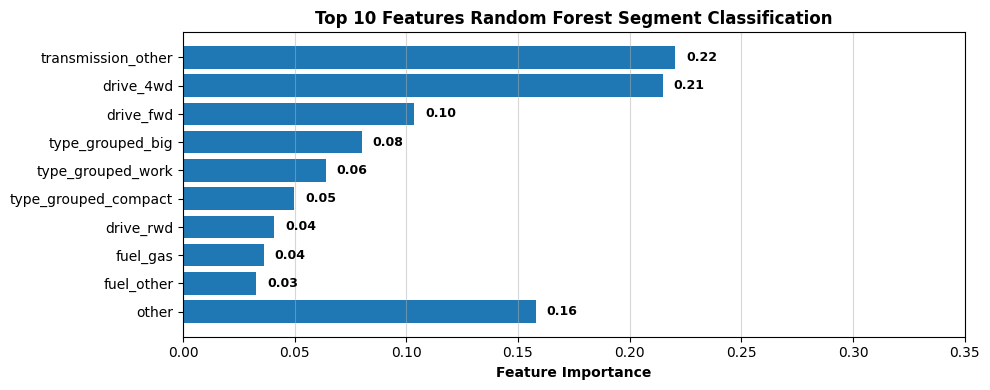

In [19]:
#Sort on Feature Importance + Top 9 and Other
df = pd.read_csv("08_feature_importance/Feature_Importance_Classification.csv")
df_sorted = df.sort_values(by='importance', ascending=False)
top9 = df_sorted.head(9)
rest_sum = df_sorted.iloc[9:]['importance'].sum()
plot_df = top9.copy()
plot_df.loc[len(top9)] = ['other', rest_sum]

#Plot
plt.figure(figsize=(10, 4))
bars = plt.barh(plot_df['feature'], plot_df['importance'], color='#1f77b4')

#Axes + Titles + Grid
plt.xlabel('Feature Importance', fontweight='bold')
plt.xlim(0, 0.35)
plt.title('Top 10 Features Random Forest Segment Classification', fontweight='bold')
plt.gca().invert_yaxis()  # belangrijk: hoogste bovenaan
plt.grid(axis='x', alpha=0.5)

#Values on Bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=9, fontweight="bold")

#Save
plt.tight_layout()
plt.savefig("09_results_visuals_pdf/Top 10 Features Random Forest Segment Classification.pdf", format='pdf', bbox_inches='tight')
plt.show()


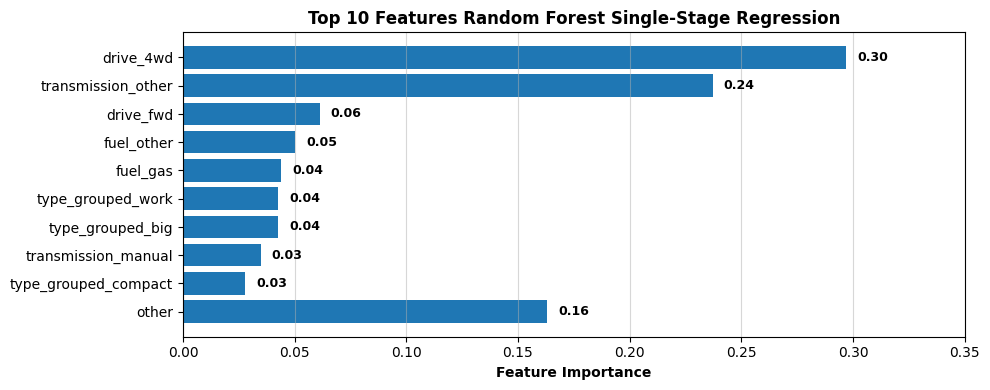

In [20]:
#Sort on Feature Importance + Top 9 and Other
df = pd.read_csv("08_feature_importance/Feature_Importance_Regression.csv")
df_sorted = df.sort_values(by='importance', ascending=False)
top9 = df_sorted.head(9)
rest_sum = df_sorted.iloc[9:]['importance'].sum()
plot_df = top9.copy()
plot_df.loc[len(top9)] = ['other', rest_sum]

#Plot
plt.figure(figsize=(10, 4))
bars = plt.barh(plot_df['feature'], plot_df['importance'], color='#1f77b4')

#Axes + Titles + Grid
plt.xlabel('Feature Importance', fontweight='bold')
plt.xlim(0, 0.35)
plt.title('Top 10 Features Random Forest Single-Stage Regression', fontweight='bold')
plt.gca().invert_yaxis()  # belangrijk: hoogste bovenaan
plt.grid(axis='x', alpha=0.5)

#Values on Bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=9, fontweight="bold")

#Save
plt.tight_layout()
plt.savefig("09_results_visuals_pdf/Top 10 Features Random Forest Single-Stage Regression.pdf", format='pdf', bbox_inches='tight')
plt.show()

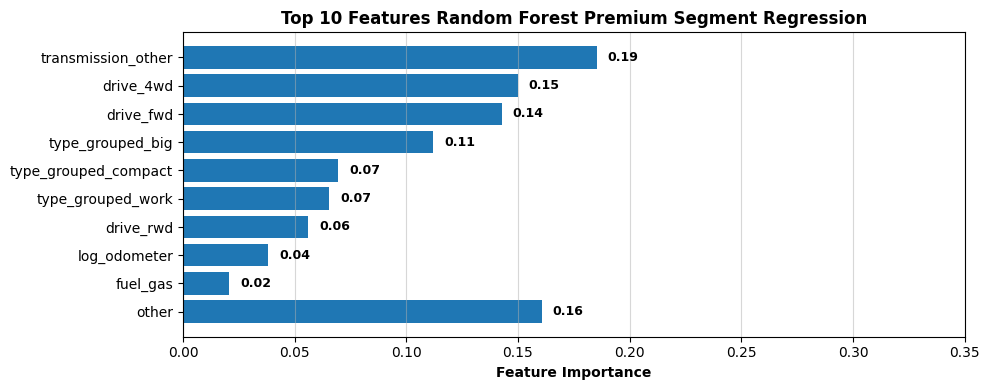

In [23]:
#Sort on Feature Importance + Top 9 and Other
df = pd.read_csv("08_feature_importance/Feature_Importance_High.csv")
df_sorted = df.sort_values(by='importance', ascending=False)
top9 = df_sorted.head(9)
rest_sum = df_sorted.iloc[9:]['importance'].sum()
plot_df = top9.copy()
plot_df.loc[len(top9)] = ['other', rest_sum]

#Plot
plt.figure(figsize=(10, 4))
bars = plt.barh(plot_df['feature'], plot_df['importance'], color='#1f77b4')

#Axes + Titles + Grid
plt.xlabel('Feature Importance', fontweight='bold')
plt.xlim(0, 0.35)
plt.title('Top 10 Features Random Forest Premium Segment Regression', fontweight='bold')
plt.gca().invert_yaxis()  # belangrijk: hoogste bovenaan
plt.grid(axis='x', alpha=0.5)

#Values on Bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=9, fontweight="bold")

#Save
plt.tight_layout()
plt.savefig("09_results_visuals_pdf/Top 10 Features Random Forest Premium Segment Regression.pdf", format='pdf', bbox_inches='tight')
plt.show()

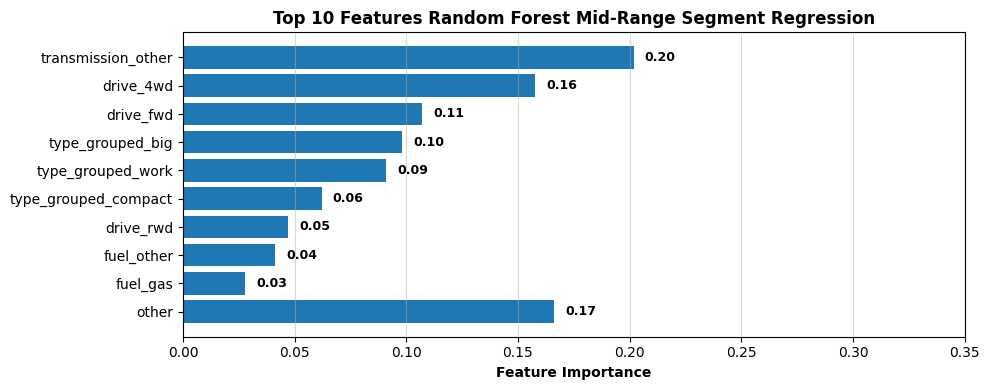

In [21]:
#Sort on Feature Importance + Top 9 and Other
df = pd.read_csv("08_feature_importance/Feature_Importance_Mid.csv")
df_sorted = df.sort_values(by='importance', ascending=False)
top9 = df_sorted.head(9)
rest_sum = df_sorted.iloc[9:]['importance'].sum()
plot_df = top9.copy()
plot_df.loc[len(top9)] = ['other', rest_sum]

#Plot
plt.figure(figsize=(10, 4))
bars = plt.barh(plot_df['feature'], plot_df['importance'], color='#1f77b4')

#Axes + Titles + Grid
plt.xlabel('Feature Importance', fontweight='bold')
plt.xlim(0, 0.35)
plt.title('Top 10 Features Random Forest Mid-Range Segment Regression', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.5)

#Values on Bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=9, fontweight="bold")

#Save
plt.tight_layout()
plt.savefig("09_results_visuals_pdf/Top 10 Features Random Forest Mid-Range Segment Regression.pdf", format='pdf', bbox_inches='tight')
plt.show()

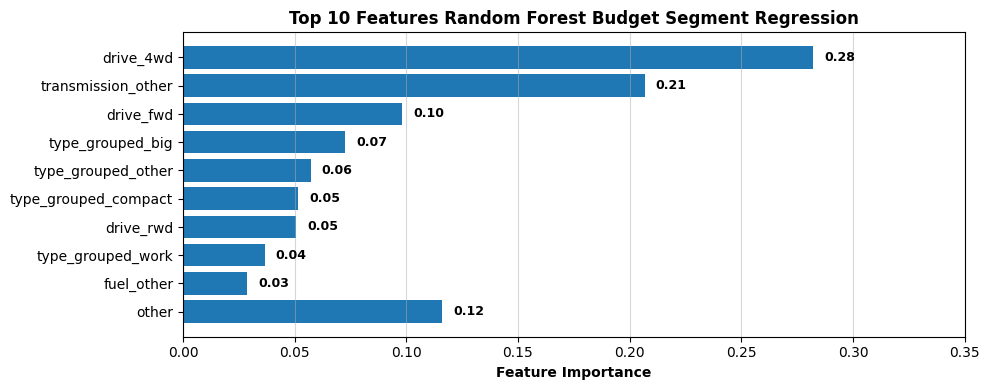

In [24]:
#Sort on Feature Importance + Top 9 and Other
df = pd.read_csv("08_feature_importance/Feature_Importance_Low.csv")
df_sorted = df.sort_values(by='importance', ascending=False)
top9 = df_sorted.head(9)
rest_sum = df_sorted.iloc[9:]['importance'].sum()
plot_df = top9.copy()
plot_df.loc[len(top9)] = ['other', rest_sum]

#Plot
plt.figure(figsize=(10, 4))
bars = plt.barh(plot_df['feature'], plot_df['importance'], color='#1f77b4')

#Axes + Titles + Grid
plt.xlabel('Feature Importance', fontweight='bold')
plt.xlim(0, 0.35)
plt.title('Top 10 Features Random Forest Budget Segment Regression', fontweight='bold')
plt.gca().invert_yaxis() 
plt.grid(axis='x', alpha=0.5)

#Values on Bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=9, fontweight="bold")

#Save
plt.tight_layout()
plt.savefig("09_results_visuals_pdf/Top 10 Features Random Forest Budget Segment Regression.pdf", format='pdf', bbox_inches='tight')
plt.show()

Code for Actual vs. Pred Visuals

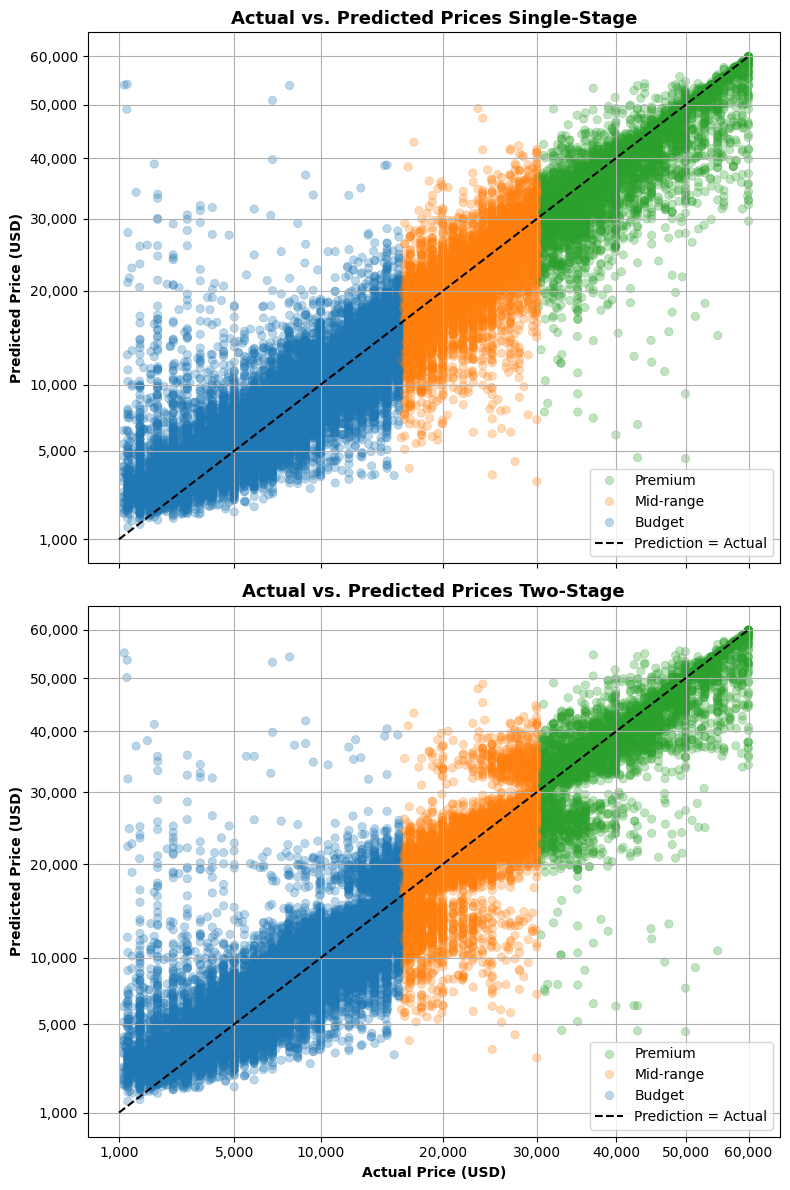

In [25]:
#Labels for Legend
label_map = {1: 'Budget', 2: 'Mid-range', 3: 'Premium'}
merged_results['segment_label'] = merged_results['segment_true'].map(label_map)

#Transform the axes with sqrt
sqrt_min = np.sqrt(1000)
sqrt_max = np.sqrt(60000)
original_ticks = [1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000]
sqrt_ticks = np.sqrt(original_ticks)
tick_labels = [f"{int(t):,}" for t in original_ticks]

#Colors and Order
palette = {'Budget': '#1f77b4', 'Mid-range': '#ff7f0e', 'Premium': '#2ca02c'}
hue_order= ['Premium', 'Mid-range', 'Budget']

#Create Double Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharex=True, sharey=True)

#1-stage
sns.scatterplot(
    data=merged_results,
    x=np.sqrt(merged_results['price_true']),
    y=np.sqrt(merged_results['1stage_pred']),
    hue='segment_label',
    hue_order=hue_order,
    palette=palette,
    alpha=0.3,
    edgecolor=None,
    ax=axes[0]
)
axes[0].plot([sqrt_min, sqrt_max], [sqrt_min, sqrt_max], linestyle='--', color='black', label='Prediction = Actual')
axes[0].set_title('Actual vs. Predicted Prices Single-Stage', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Predicted Price (USD)', fontweight='bold')
axes[0].legend()
axes[0].grid(True)                     

#2-stage
sns.scatterplot(
    data=merged_results,
    x=np.sqrt(merged_results['price_true']),
    y=np.sqrt(merged_results['2stage_pred']),
    hue='segment_label',
    hue_order=hue_order,
    palette=palette,
    alpha=0.3,
    edgecolor=None,
    ax=axes[1]
)
axes[1].plot([sqrt_min, sqrt_max], [sqrt_min, sqrt_max], linestyle='--', color='black', label='Prediction = Actual')
axes[1].set_title('Actual vs. Predicted Prices Two-Stage', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Actual Price (USD)', fontweight='bold')
axes[1].set_ylabel('Predicted Price (USD)', fontweight='bold')
axes[1].legend()
axes[1].grid(True)    

#Change Axes
axes[1].set_xticks(sqrt_ticks)
axes[1].set_xticklabels(tick_labels)
axes[1].set_yticks(sqrt_ticks)
axes[1].set_yticklabels(tick_labels)

#Save
plt.tight_layout()
plt.savefig("09_results_visuals_pdf/ActualPredicted_Models.pdf", format='pdf', bbox_inches='tight')
plt.show()


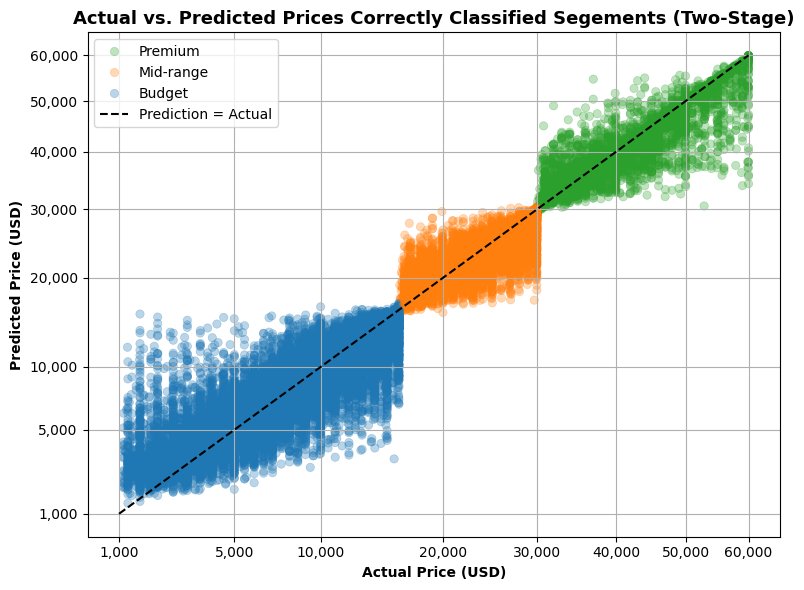

In [26]:
#Filter to Only Have Correct Classes
correct_class = merged_results[merged_results['segment_pred'] == merged_results['segment_true']].copy()
label_map = {1: 'Budget', 2: 'Mid-range', 3: 'Premium'}
correct_class['segment_label'] = correct_class['segment_true'].map(label_map)

#Transform the axes with sqrt
sqrt_min = np.sqrt(1000)
sqrt_max = np.sqrt(60000)
original_ticks = [1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000]
sqrt_ticks = np.sqrt(original_ticks)
tick_labels = [f"{int(t):,}" for t in original_ticks]

#Colors and Order
palette = {'Budget': '#1f77b4', 'Mid-range': '#ff7f0e', 'Premium': '#2ca02c'}
hue_order = ['Premium', 'Mid-range','Budget'] 

#Start Plot
fig, ax = plt.subplots(figsize=(8, 6))

#Only Correct Classes
sns.scatterplot(
    data=correct_class,
    x=np.sqrt(correct_class['price_true']),
    y=np.sqrt(correct_class['2stage_pred']),
    hue='segment_label',
    hue_order=hue_order,
    palette=palette,
    alpha=0.3,
    edgecolor=None,
    ax=ax
)
#Titles
ax.plot([sqrt_min, sqrt_max], [sqrt_min, sqrt_max], linestyle='--', color='black', label='Prediction = Actual')
ax.set_title('Actual vs. Predicted Prices Correctly Classified Segements (Two-Stage)', fontsize=13, fontweight='bold')
ax.set_xlabel('Actual Price (USD)', fontweight='bold')
ax.set_ylabel('Predicted Price (USD)', fontweight='bold')

#Axes
ax.set_xticks(sqrt_ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(sqrt_ticks)
ax.set_yticklabels(tick_labels)
ax.legend()
ax.grid(True)

#Save
plt.tight_layout()
plt.savefig("09_results_visuals_pdf/ActualPredicted_Correct.pdf", format='pdf', bbox_inches='tight')
plt.show()